[![View notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2023/fig_convergence.ipynb)
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Arabas_et_al_2023/fig_convergence.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Arabas_et_al_2023/fig_convergence.ipynb)

In [5]:
import numpy as np
from matplotlib import pyplot

from PySDM import Builder, Formulae
from PySDM.dynamics import Freezing
from PySDM.environments import Box
from PySDM.physics import constants_defaults as const
from PySDM.physics import si
from PySDM.products import IceWaterContent
from PySDM.backends import CPU, GPU

from open_atmos_jupyter_utils import show_plot

In [2]:
def _plot_fit(fit_x_arg, fit_y_arg, low_arg, hgh_arg, total_time_arg):
    pyplot.plot(
        fit_x_arg, fit_y_arg, color="black", linestyle="--", label="theory", linewidth=5
    )
    pyplot.plot(
        fit_x_arg, hgh_arg(fit_x_arg), color="black", linestyle=":", label="assert upper bound"
    )
    pyplot.plot(
        fit_x_arg, low_arg(fit_x_arg), color="black", linestyle=":", label="assert lower bound"
    )
    pyplot.legend()
    pyplot.yscale("log")
    pyplot.ylim(fit_y_arg[-1], fit_y_arg[0])
    pyplot.xlim(None, total_time_arg)
    pyplot.xlabel("time [s]")
    pyplot.ylabel("unfrozen fraction")
    pyplot.grid()

In [ ]:
seed = 44
cases = (
    {"dt": 5e5, "N": 1},
    {"dt": 1e6, "N": 1},
    {"dt": 5e5, "N": 8},
    {"dt": 1e6, "N": 8},
    {"dt": 5e5, "N": 16},
    {"dt": 1e6, "N": 16},
)
rate = 1e-9 / si.s
immersed_surface_area = 1 * si.m

number_of_real_droplets = 1024
total_time = (
    0.25e9  # effectively interpreted here as seconds, i.e. cycle = 1 * si.s
)

# dummy (but must-be-set) values
vol = (
    44  # for sign flip (ice water has negative volumes), value does not matter
)
d_v = 666  # products use conc., dividing there, multiplying here, value does not matter

def hgh(t):
    return np.exp(-0.75 * rate * (t - total_time / 4))

def low(t):
    return np.exp(-1.25 * rate * (t + total_time / 4))


# Act
output = {}

products = (IceWaterContent(name="qi"),)

formulae = Formulae(
    particle_shape_and_density="MixedPhaseSpheres",
    heterogeneous_ice_nucleation_rate="Constant",
    constants={"J_HET": rate / immersed_surface_area},
    seed=seed,
)

for backend_class in (CPU, GPU):
    backend_key = backend_class.__name__
    output[backend_key] = {}
    for case in cases:
        n_sd = int(number_of_real_droplets // case["N"])
        assert n_sd == number_of_real_droplets / case["N"]
        assert total_time // case["dt"] == total_time / case["dt"]

        key = f"{case['dt']}:{case['N']}"
        output[backend_key][key] = {"unfrozen_fraction": [], "dt": case["dt"], "N": case["N"]}

        env = Box(dt=case["dt"], dv=d_v)
        builder = Builder(n_sd=n_sd, backend=backend_class(formulae=formulae), environment=env)
        builder.add_dynamic(Freezing(singular=False))
        attributes = {
            "multiplicity": np.full(n_sd, int(case["N"])),
            "immersed surface area": np.full(n_sd, immersed_surface_area),
            "volume": np.full(n_sd, vol),
        }
        particulator = builder.build(attributes=attributes, products=products)
        env["RH"] = 1.0001
        env["a_w_ice"] = np.nan
        env["T"] = np.nan

        cell_id = 0
        for i in range(int(total_time / case["dt"]) + 1):
            particulator.run(0 if i == 0 else 1)

            ice_mass_per_volume = particulator.products["qi"].get()[cell_id]
            ice_mass = ice_mass_per_volume * d_v
            ice_number = ice_mass / (const.rho_w * vol)
            unfrozen_fraction = 1 - ice_number / number_of_real_droplets
            output[backend_key][key]["unfrozen_fraction"].append(unfrozen_fraction)

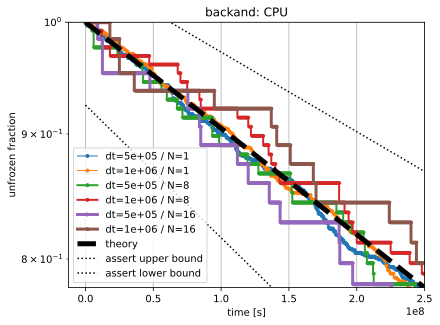

HTML(value="<a href='./fig_convergence_CPU.pdf' target='_blank'>./fig_convergence_CPU.pdf</a><br>")

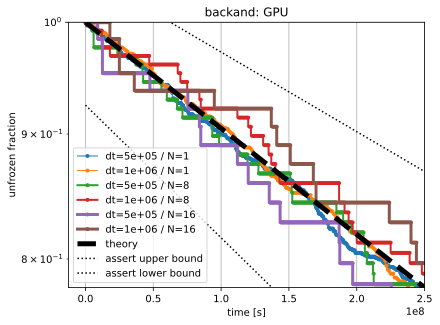

HTML(value="<a href='./fig_convergence_GPU.pdf' target='_blank'>./fig_convergence_GPU.pdf</a><br>")

In [4]:
for backend_key, backend_label in {'Numba': 'CPU', 'ThrustRTC': 'GPU'}.items():
    for out in output[backend_key].values():
        fit_x = np.linspace(0, total_time, num=100)
        fit_y = np.exp(-rate * fit_x)

        pyplot.step(
            out["dt"] * np.arange(len(out["unfrozen_fraction"])),
            out["unfrozen_fraction"],
            label=f"dt={out['dt']:.2g} / N={out['N']}",
            marker=".",
            linewidth=1 + out["N"] // 8,
        )
    _plot_fit(fit_x, fit_y, low, hgh, total_time)
    pyplot.title(f"backand: {backend_label}")
    show_plot(f"fig_convergence_{backend_label}.pdf")